In [239]:
import numpy as np
import os
from math import sqrt
from shapely.geometry import Point

from pathlib import Path
from pims import ImageSequence
from skimage.color import rgb2grey
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.measure import find_contours
import skimage as sk

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
sns.set()

# from data_io.data_loading import DataLoader
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
sys.path.insert(0, '../data_io/')

In [14]:
from data_loading import DataLoader

In [16]:
filepath = '../data/Atta/CG379_14_63xZ2_Ca_li/'
DataLoader(filepath)

TypeError: __init__() missing 1 required positional argument: 'sequence_adjust_params'

In [7]:
paths = Path('../data/Atta/CG379_14_63xZ2_Ca_li/')
image_paths = [i for i in paths.iterdir() if ".tif" in str(i)]
meta_data_path = [i for i in paths.iterdir() if ".txt" in str(i)][0]

grey_sequence = ImageSequence(image_paths, as_grey=True)
images = grey_sequence(images)

with open(str(meta_data_path), "r", encoding="latin-1") as fid:
    text_file = fid.readlines()

for line in text_file:
    if "Voxel-Height" in line.split():
        meta_data["voxel_size"] = float(line.split()[-1][:-1])
    elif "Voxel_Depth" in line.split():
        meta_data["voxel_depth"] = float(line.split()[-1][:-1])

TypeError: 'ImageSequence' object is not callable

In [196]:
params = {'y_start': 200,
         'x_start': 400, 
         'lower_threshold': 100, 
         'upper_threshold': 100,
         'square_size': 20}
filepath = '../data/Atta/CG379_14_63xZ2_Ca_li/'
sc = DataLoader(filepath, params)

images = sc.final_images
meta_data = sc.meta_data


NameError: name 'j' is not defined

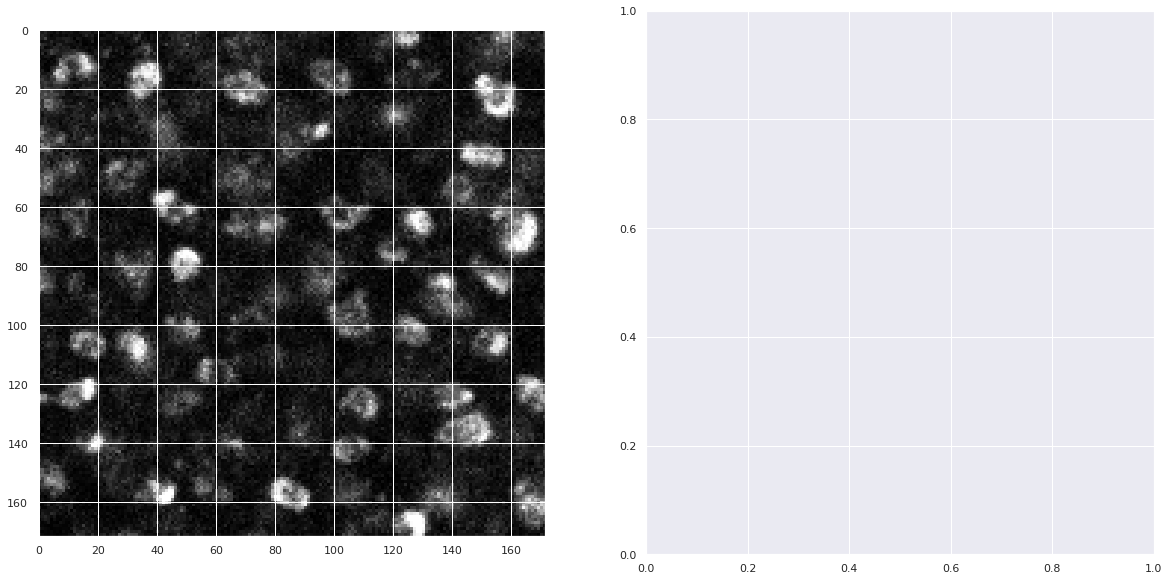

In [197]:
im = sc.cropped_images[0]
f, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(im, cmap='gray')
j

<ipython-input-147-27fdcd577299>:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(im.flatten(), bins=range(0,256,5), normed=False, alpha=0.1)


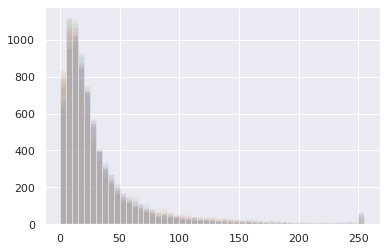

In [147]:
f, ax = plt.subplots(1,1)
for i in range(10):
    im = sc.cropped_images[i]
    ax.hist(im.flatten(), bins=range(0,256,5), normed=False, alpha=0.1)

[]

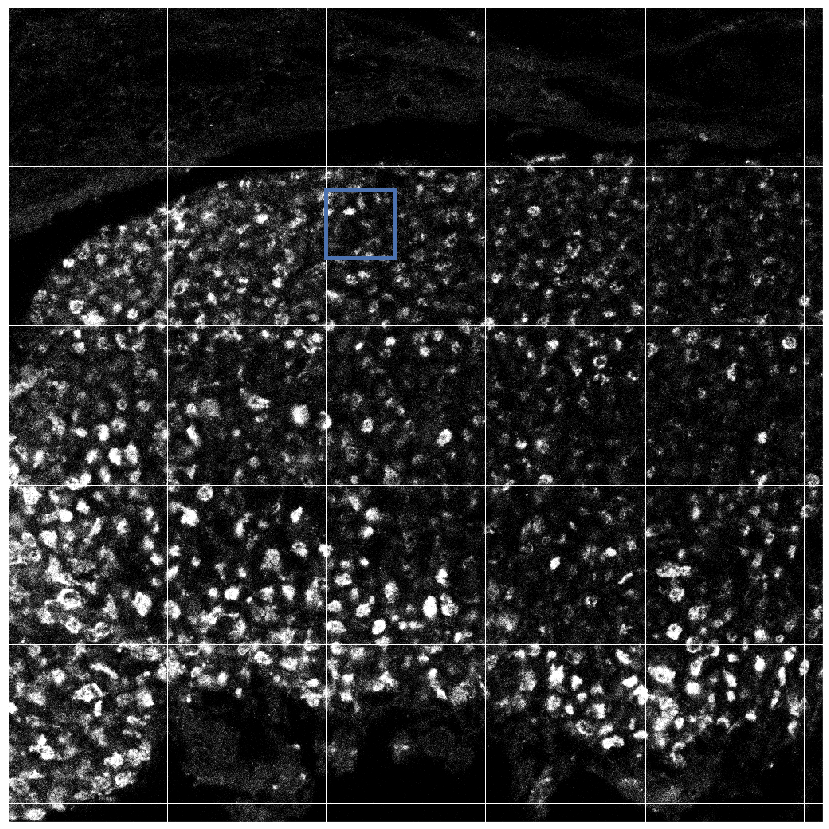

In [257]:
iii = sc.images[0]
fig, ax = plt.subplots(1,1, figsize=[15, 15])
ax.imshow(iii, cmap='gray')
width, height = sc.cropped_images[0].shape
r = patches.Rectangle((params['x_start'], params['y_start']),width,height,color='b', fill=False, linewidth=4)

ax.add_patch(r)
ax.set_xticklabels([])
ax.set_yticklabels([])

0.29298877716064453
1.4242806434631348


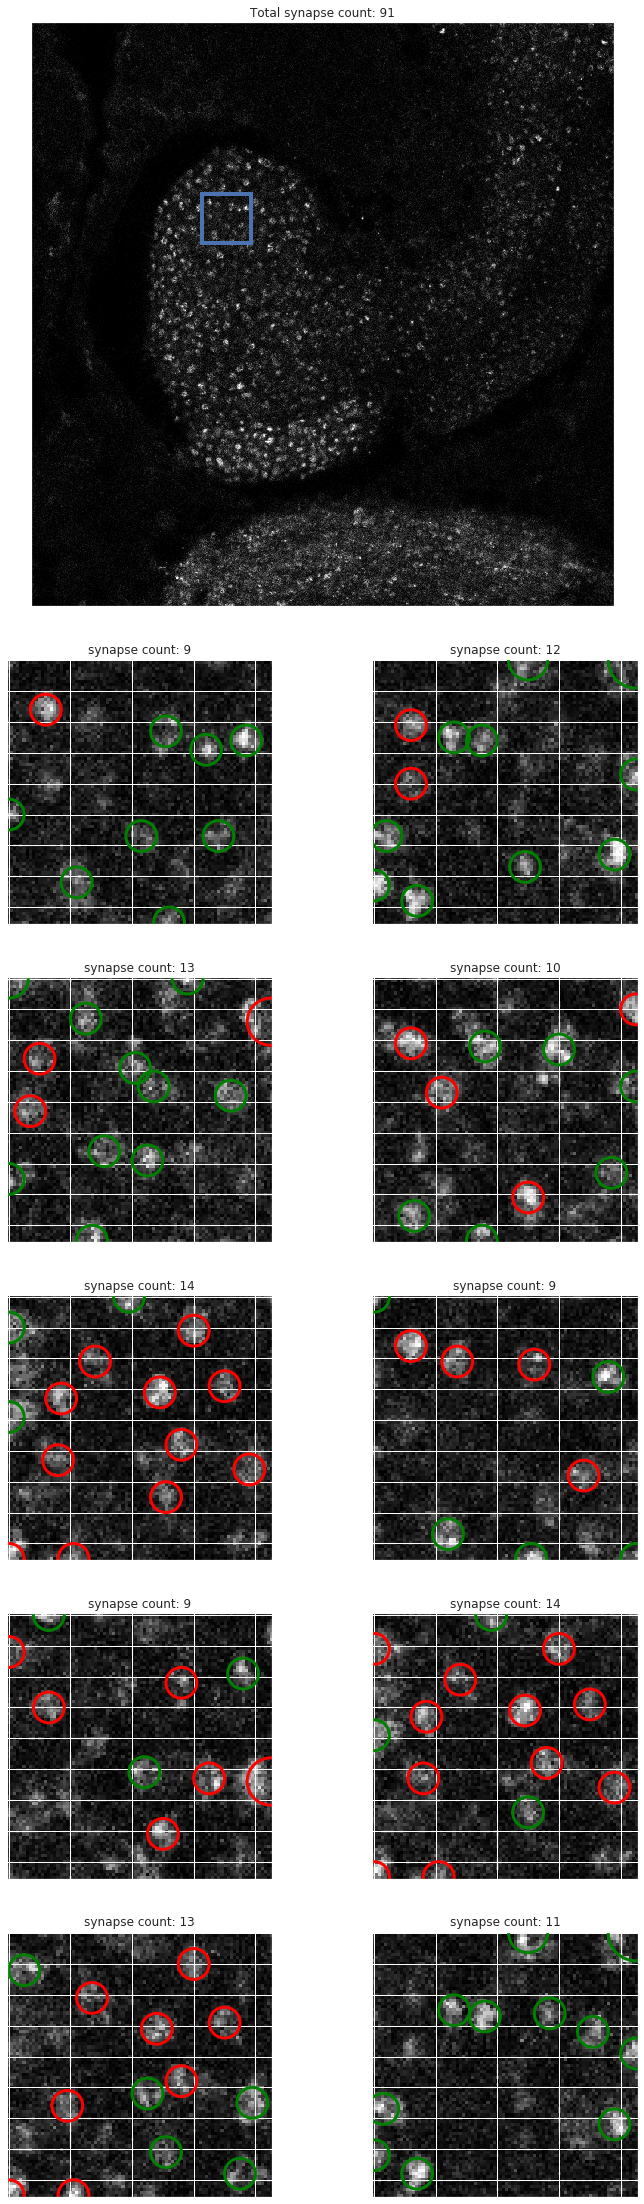

In [383]:
import time as dt
first = dt.time()
params = {'y_start': 300,
         'x_start': 300, 
         'lower_threshold': 0, 
         'upper_threshold': 255,
         'square_size': 10}
filepath = '../data/Atta/CG379_24_63xZ2_Ca_re_2/'
sc = DataLoader(filepath, params)

images = sc.final_images
meta_data = sc.meta_data

blobs = {}
th = 0
nr =  10
fig = plt.figure(figsize=(12,40))
ax = []
for key in range(nr):
    ax.append(plt.subplot2grid((7, 2), (math.floor(key/2) + 2, key%2)))
ax_big = plt.subplot2grid((7, 2), (0, 0), colspan=2, rowspan=2)
    
for i in range(nr):
    im2 = sc.cropped_images[i].copy()
    im2[im2<=th] = 0
    im2[im2>th] = im2[im2>th] - th
    im2 = im2/im2.max()
    min_sigma = 5
    max_sigma = 9
    f = blob_log(im2, min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=(max_sigma - min_sigma),threshold=0.1)
    blobs[i] = []
    for blob in f:
        blob_center = Point(blob[0], blob[1])
        blob_center.buffer = blob[2]
        blobs[i].append(blob_center)
        
num_synapes = 0
overlapping = []
for key in range(len(blobs.keys()) - 1):
    blobs_1 = blobs[key]
    blobs_2 = blobs[key + 1]
    for blob in blobs_1:
        if blob not in overlapping:
            for blob_2 in blobs_2: 
                allowed_dist = (blob.buffer + blob_2.buffer) * 2/3
                if blob.distance(blob_2) <= allowed_dist:
                    overlapping.extend([blob, blob_2])
            num_synapes += 1
last_key = max(blobs.keys())
for blob in blobs[last_key]:
    if blob not in overlapping:
        num_synapes += 1
second = dt.time()
        
for key, value in blobs.items():
    im = sc.cropped_images[key]
    ca = ax[key]
    
    
    ca.imshow(im, cmap='gray')
    for blob in value:
        ca.set_xticklabels([])
        ca.set_yticklabels([])
        color = 'red' if blob in overlapping else 'green'
        circle = plt.Circle((blob.y, blob.x), blob.buffer, color=color, linewidth=3, fill=False)
        ca.add_patch(circle)
    ca.set_title(f'synapse count: {len(value)}')

iii = sc.images[0]
ax_big.imshow(iii, cmap='gray')
width, height = sc.cropped_images[0].shape
r = patches.Rectangle((params['x_start'], params['y_start']),width,height,color='b', fill=False, linewidth=4)

ax_big.add_patch(r)
ax_big.set_xticks([])
ax_big.set_yticks([])
ax_big.set_title(f'Total synapse count: {num_synapes}')
filename = f'blobs_{num_synapes}.png'
savepath = Path(filepath) / filename
fig.savefig(savepath)
third = dt.time()
print(second-first)
print(third-second)

In [102]:
def laplacian_of_gaussian(image):                                    
    minimum = 2                               
    maximum = 30 
    threshold = 0.2                      
    num_sigma=200
    overlap=0.7
                   
    blobs_log = blob_log(                                     
        image,                                                
        min_sigma=minimum,                             
        max_sigma=maximum,                             
        num_sigma=num_sigma,
        threshold=threshold,                             
        overlap=overlap
    )                                                                               
    radii = [b[2] for b in blobs_log]                                                                  
                                                                  
    return blobs_log, radii

def _plot_log_blobs(blobs, image):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    for blob in blobs:
        ax.imshow(image, interpolation='nearest')
        y, x, r = blob
        c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
        ax.add_patch(c)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def _plot_log_blobs2(blobs, image, ax=None):
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
        ax.add_patch(c)

def _analyse_blob_radii(radii):
    median = np.median(radii)
    mean = np.mean(radii)
    std = np.std(radii)
    return median, mean, std

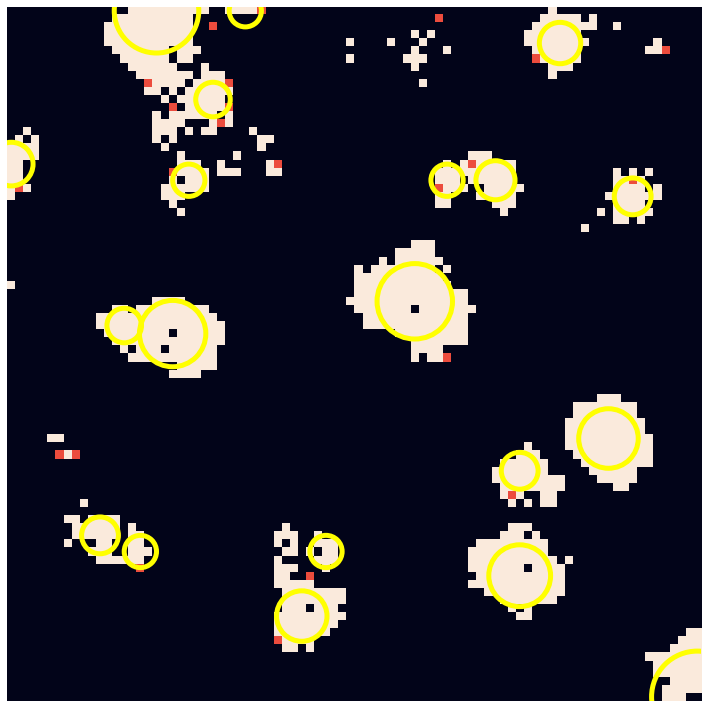

/mnt/data/repositories/automatic-synapse-counting/venv/lib/python3.8/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/mnt/data/repositories/automatic-synapse-counting/venv/lib/python3.8/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/mnt/data/repositories/automatic-synapse-counting/venv/lib/python3.8/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/mnt/data/repositories/automatic-synapse-counting/venv/lib/python3.8/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


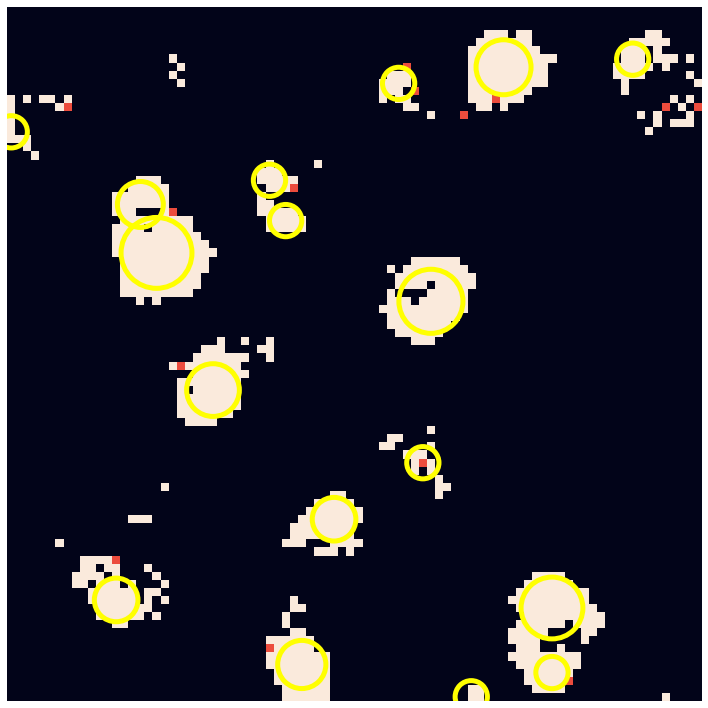

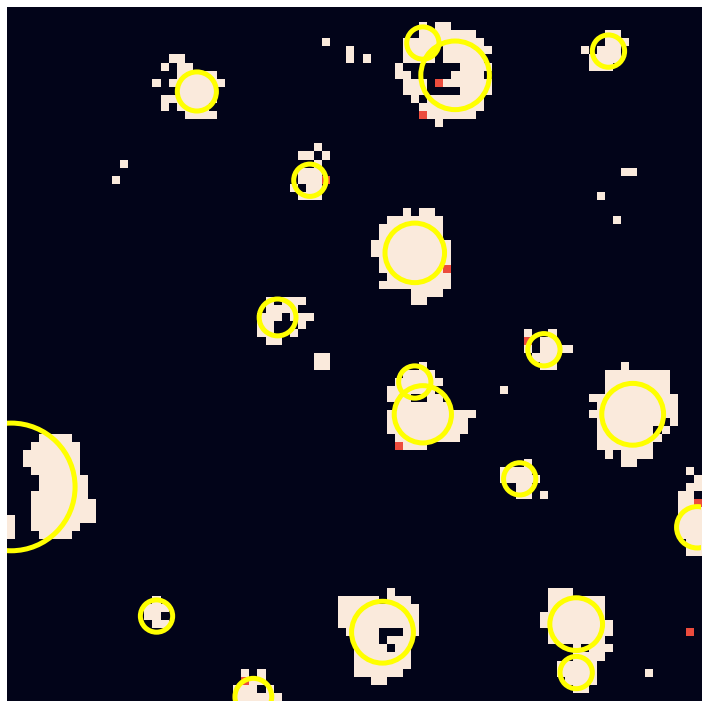

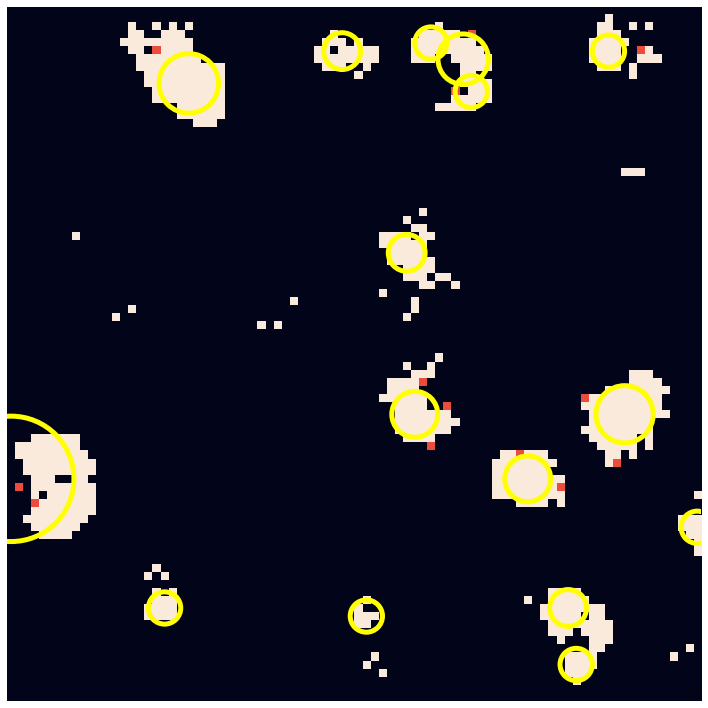

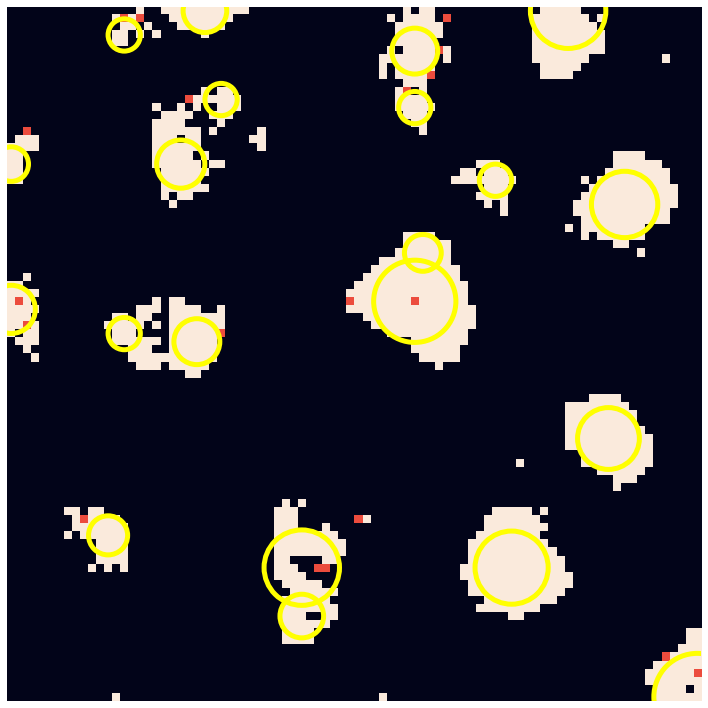

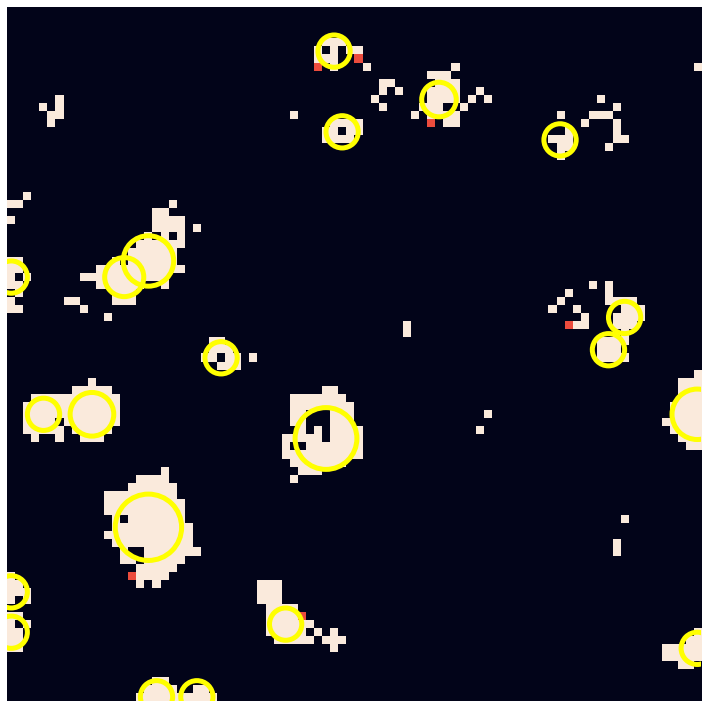

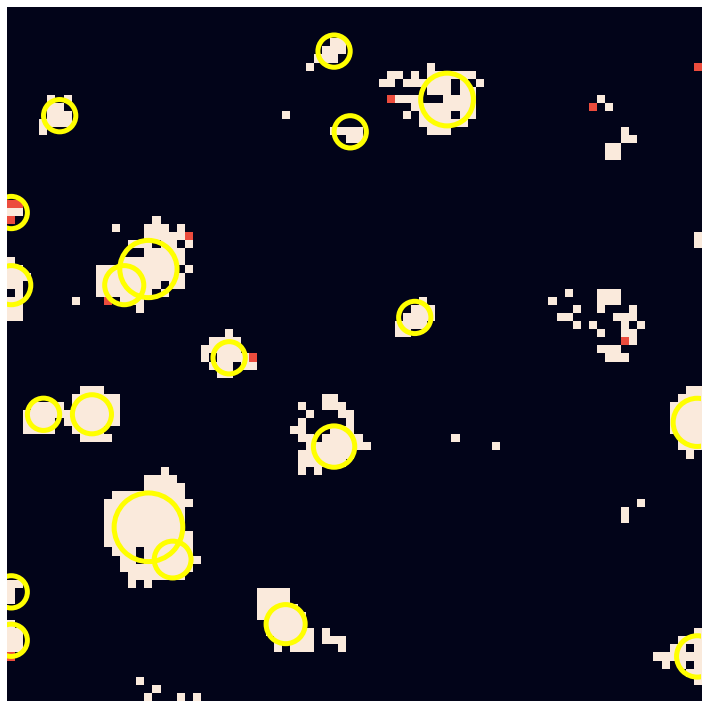

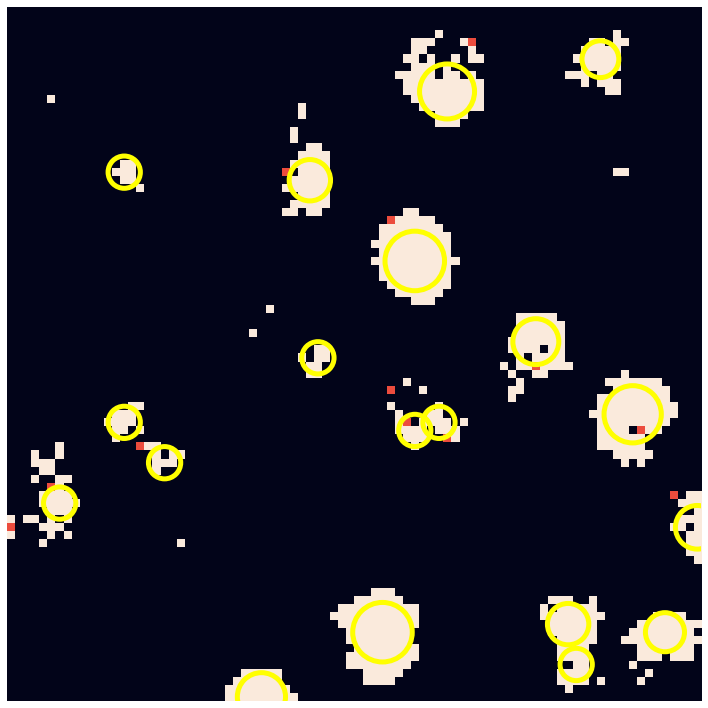

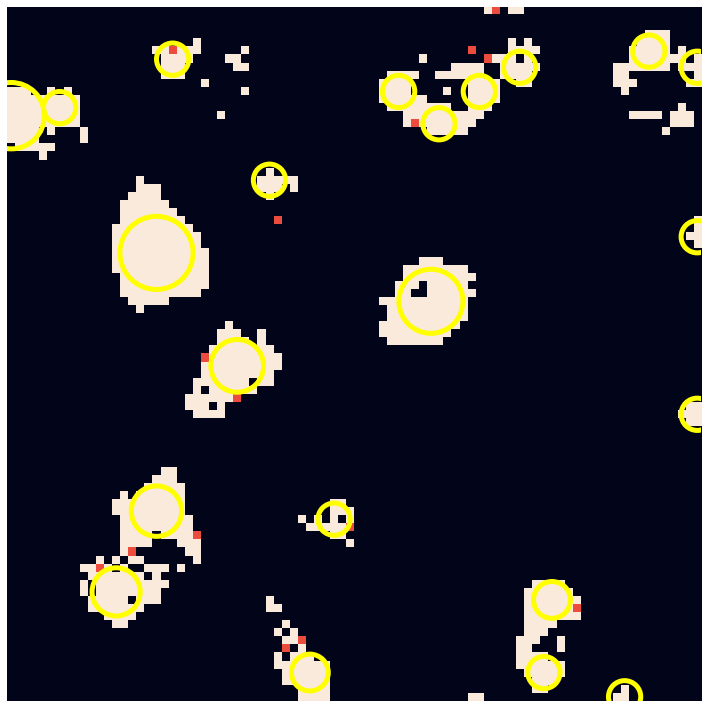

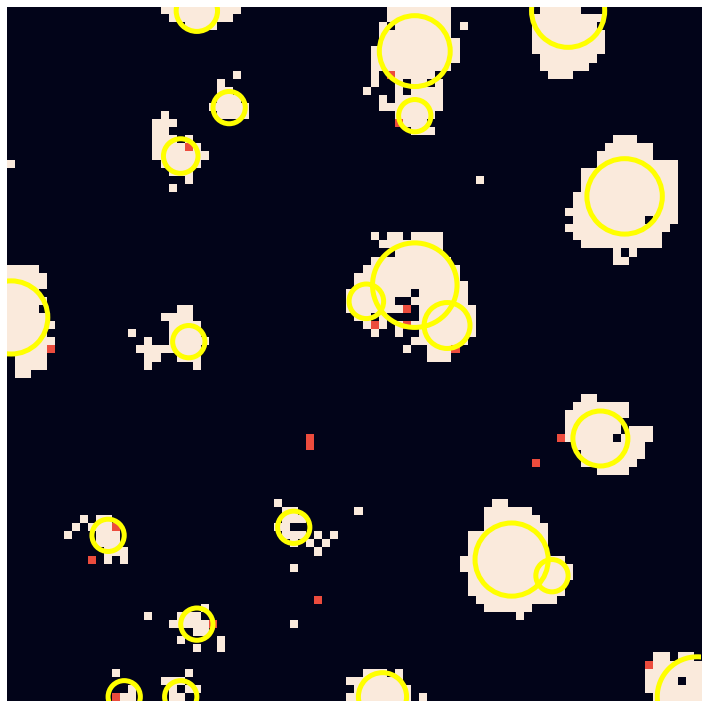

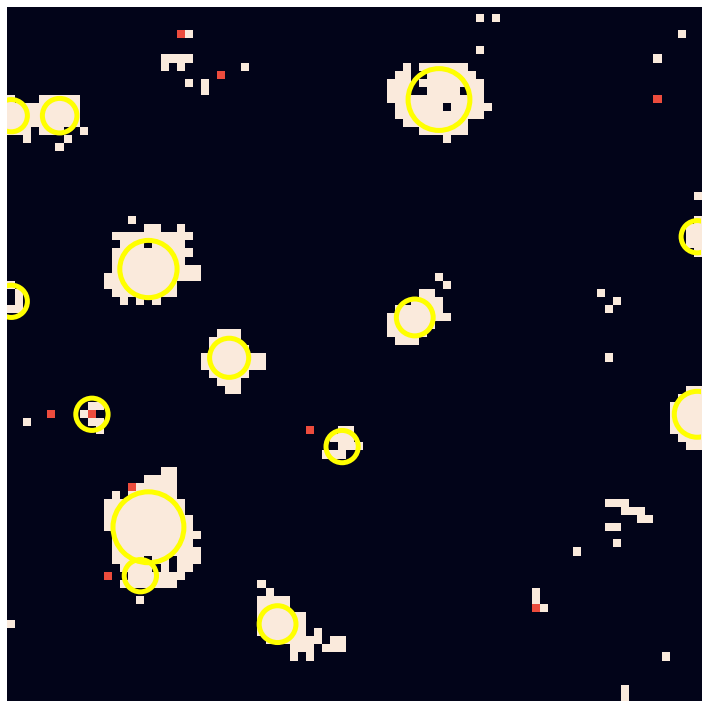

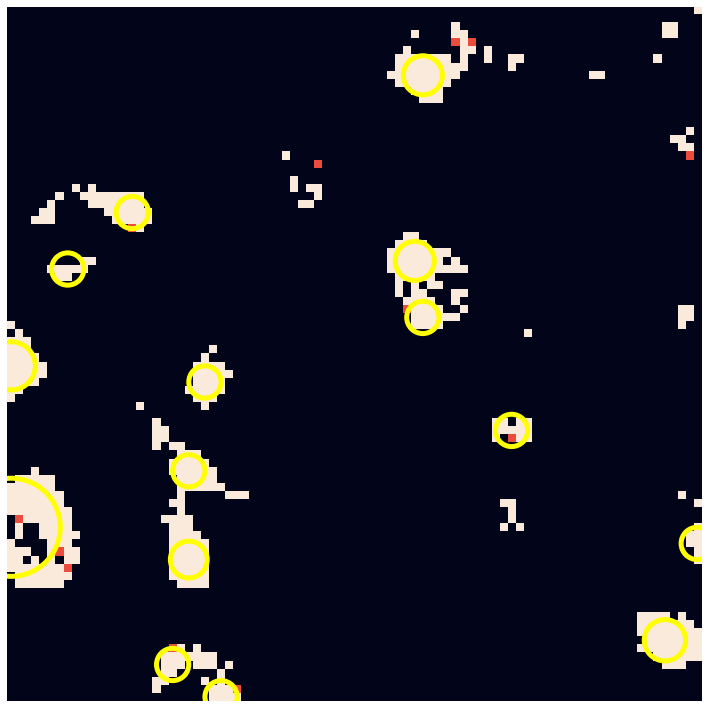

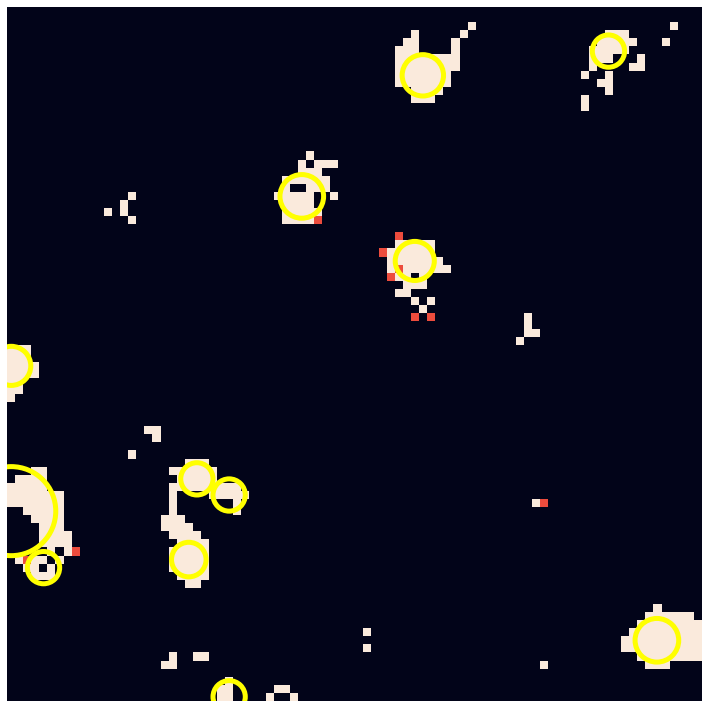

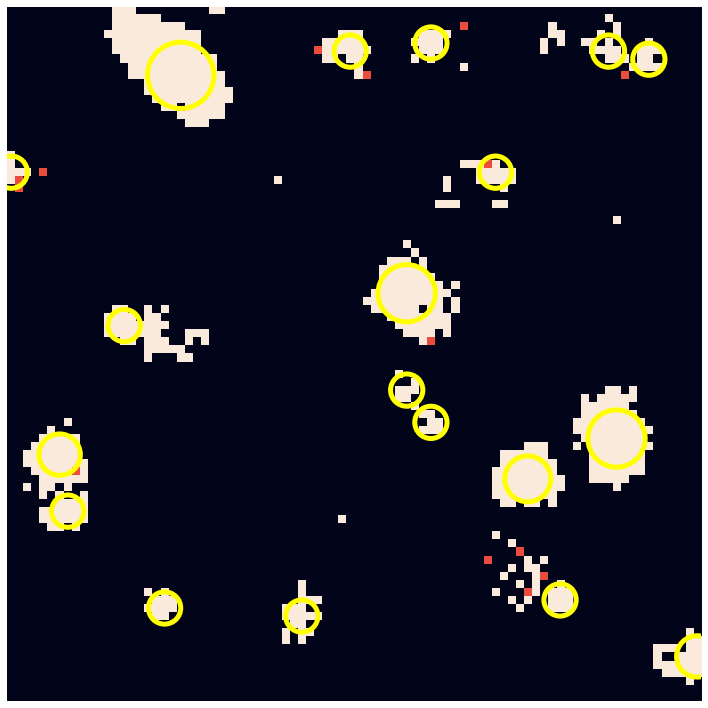

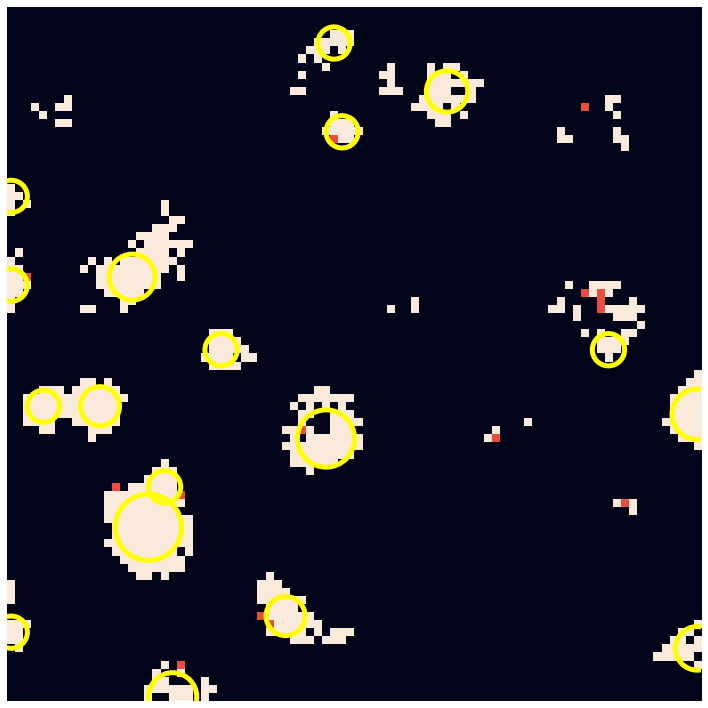

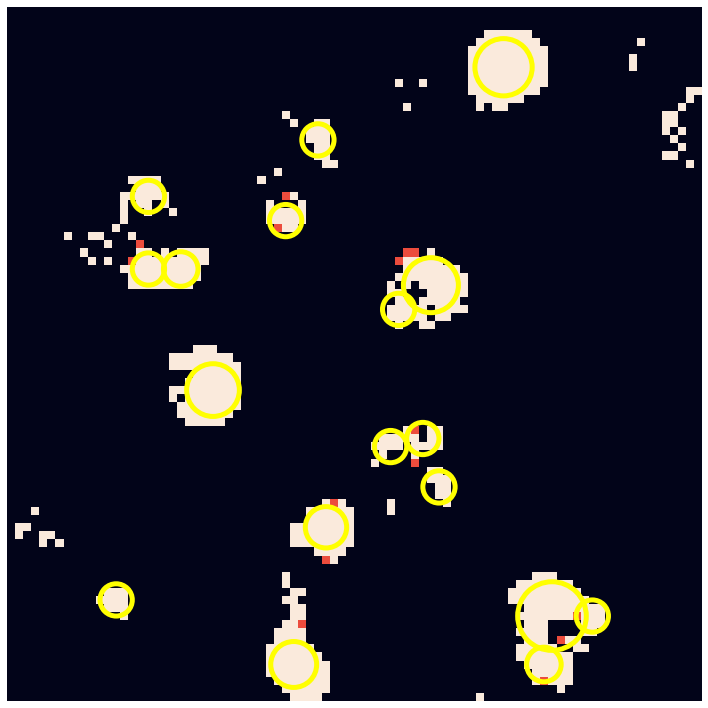

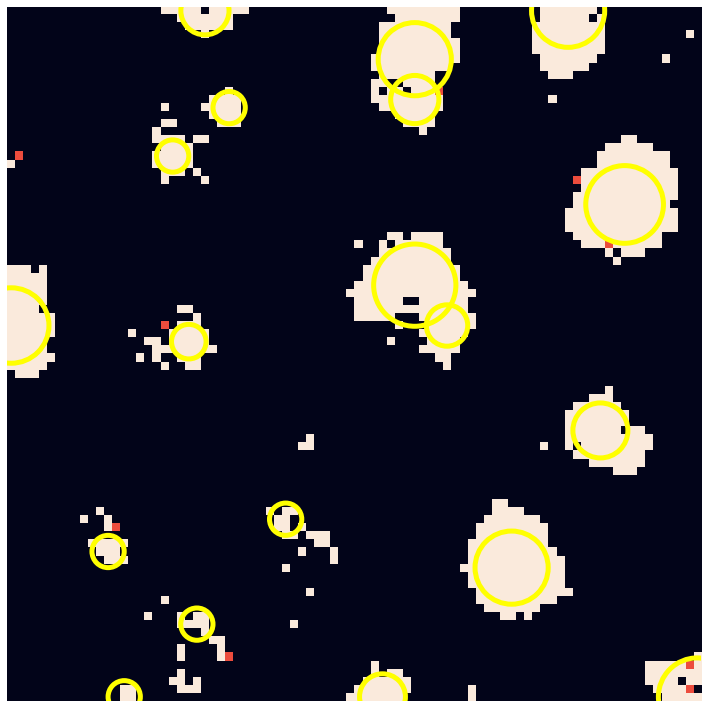

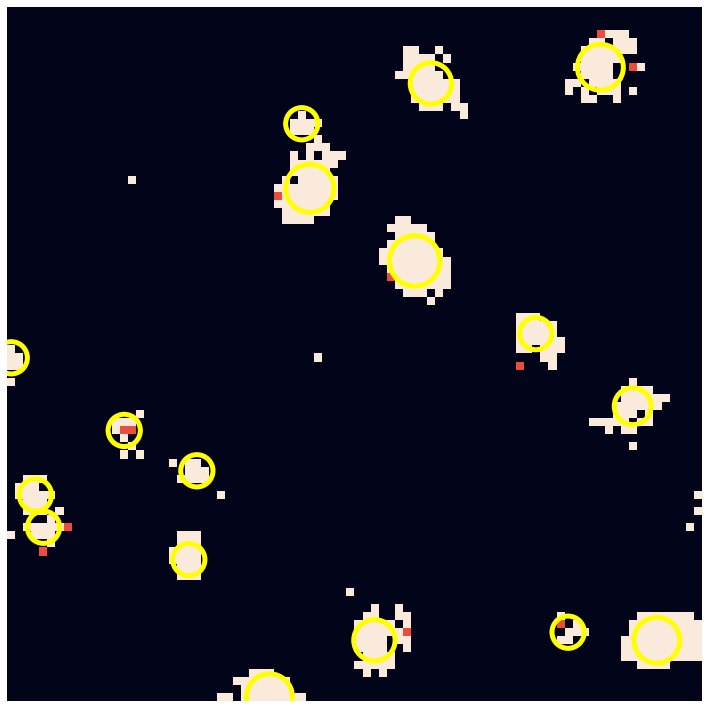

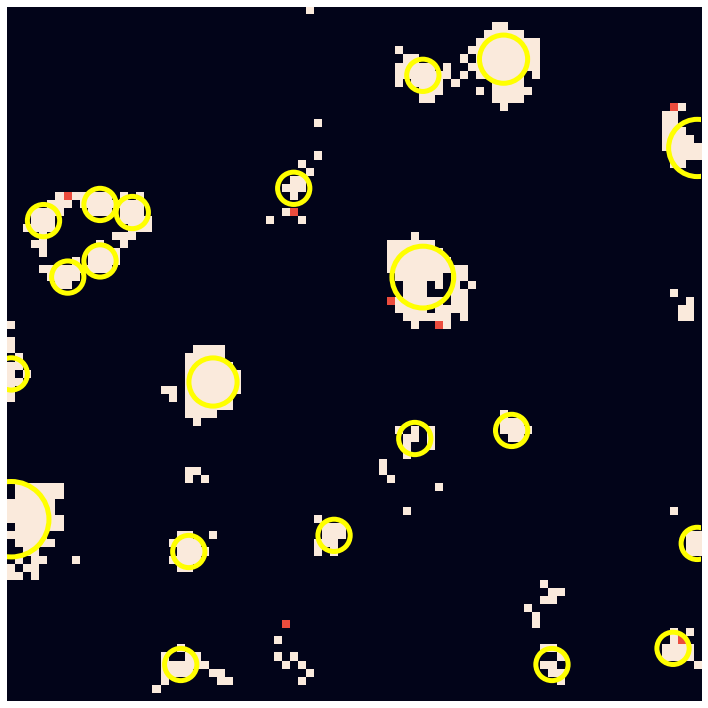

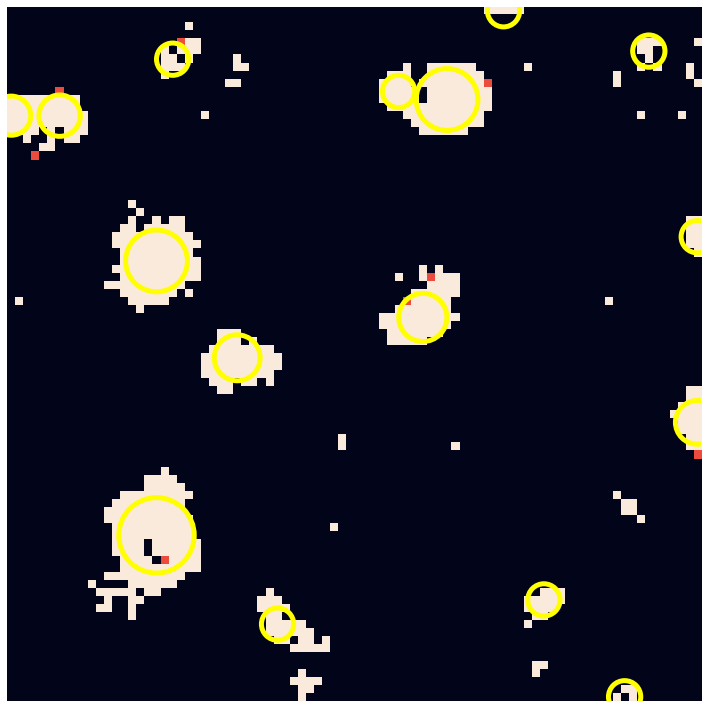

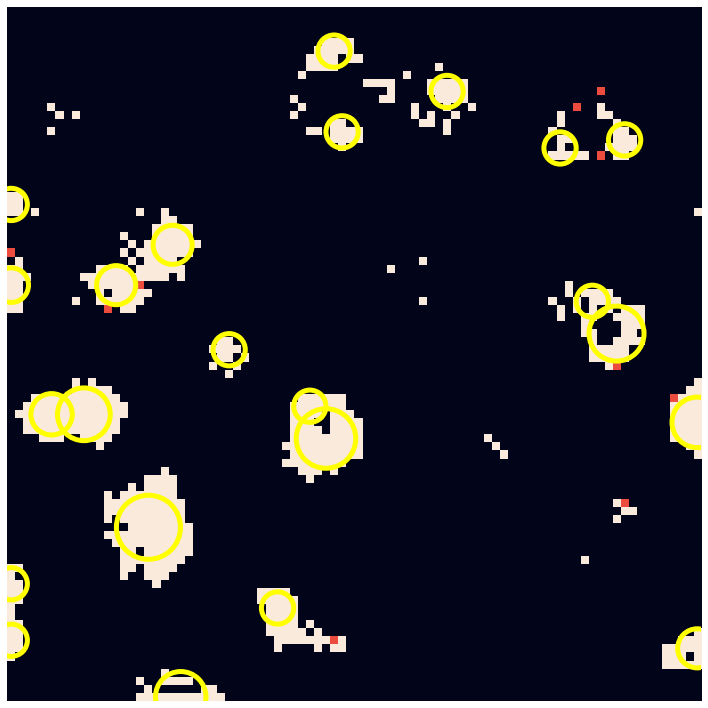

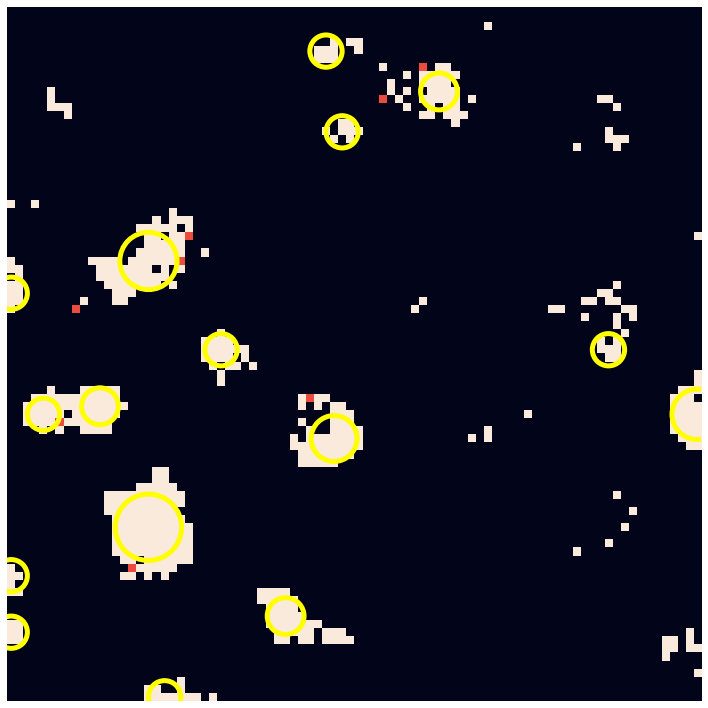

In [32]:
radius_data = {}
blobs_data = {}
radii_raw = {}
for i, image in enumerate(images):
    blobs, radii = laplacian_of_gaussian(image)
    blobs_data[i] = blobs
    radii_raw[i] = radii
    _plot_log_blobs(blobs, image)
    radius_data[i] = _analyse_blob_radii(radii)

In [69]:
all_radii = list()
all_radii.append([v for k, v in radii_raw.items()])